In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
from statsmodels.tsa.stattools import adfuller

def adf_test(df):
  dftest = adfuller(df, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

  print("----------")

  return dftest[1]

In [3]:
df = pd.read_csv("water.csv")
df["date_time"] = pd.to_datetime(df["date_time"])
# df.info()
# df

In [4]:
df_train = df.drop(["date","time"],axis=1)

In [5]:
# df_train = df_train.resample("10T", on="date_time").mean().interpolate(method="time")
my_order = 3
my_s = 10
df_train = df_train.resample("10T",on="date_time").mean().interpolate(method="spline",order=my_order,s=my_s)
df_train.reset_index(inplace=True)
# df_train

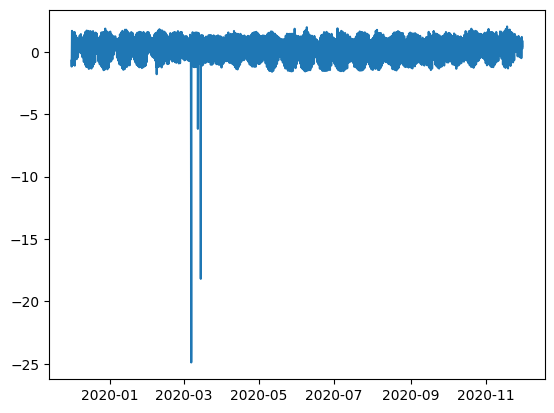

In [6]:
plt.plot(df_train["date_time"],df_train["water"])

In [7]:
df_train = df_train.loc[(df_train["water"] >= -11.65) & (df_train["water"] <= 11.65)]

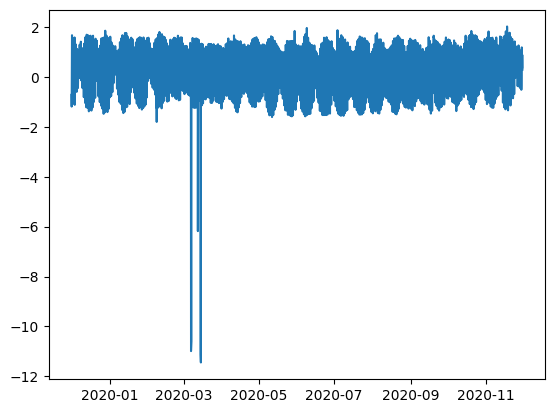

In [8]:
plt.plot(df_train["date_time"],df_train["water"])

In [9]:
df_train["water_diff"] = df_train["water"].diff()

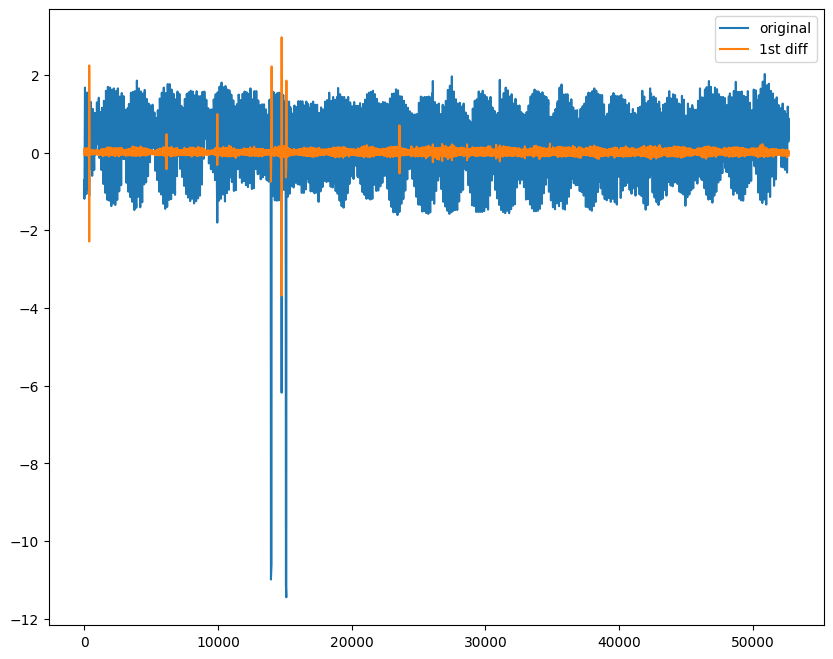

In [10]:
plt.figure(figsize=(10,8))
df_train["water"].plot(label = "original")
df_train["water_diff"].plot(label="1st diff")
plt.legend()

In [14]:
adf_test(df_train["water"])
adf_test(df_train["water_diff"].dropna())

1. ADF :  -34.68910934688773
2. P-Value :  0.0
3. Num Of Lags :  58
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 52542
5. Critical Values :
	 1% :  -3.430474464609389
	 5% :  -2.861595010859839
	 10% :  -2.5667992804511055
----------
1. ADF :  -50.62712277605605
2. P-Value :  0.0
3. Num Of Lags :  44
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 52555
5. Critical Values :
	 1% :  -3.4304744338203306
	 5% :  -2.8615949972519785
	 10% :  -2.5667992732080442
----------


0.0